In [3]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [1]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [4]:
from models.Wang2020 import M4
net = M4(N_layers=8, width=32, alpha=0.9).to(device)

In [5]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

RandomMeshSDFDataset (10000 points)


In [6]:
use_random_sdf = isinstance(train_dataset, RandomMeshSDFDataset)
points = train_dataset.points if use_random_sdf else train_dataset.pde_points
sdfs = train_dataset.sdfs if use_random_sdf else train_dataset.bc_sdfs

In [7]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [9]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
points.requires_grad_(True)
try:
    for epoch in range(max_epochs):
        # Training
        optimizer.zero_grad()
        y = net(points)
        loss = net.loss(y, points, points, sdfs)
        loss.backward(retain_graph=True)
      
        lr_scheduler.optimizer.step(lambda: loss)
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        
        if epoch % 20 == 19:
            y = net(points)
            net.adaptive_lambda(y, points, points, sdfs)

        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda[0]:.6f}')
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.656287, 0.104705, 1.000000
#100 Loss: 1.590091, 0.004488, 289.320923
#200 Loss: 4.686083, 0.001364, 3163.426025
#300 Loss: 6.898065, 0.001110, 5905.527832
#400 Loss: 23.959557, 0.001059, 22307.181641
#500 Loss: 23.568911, 0.001022, 22735.949219
#600 Loss: 114.780052, 0.001007, 113598.929688
#700 Loss: 142.844864, 0.000968, 147260.468750
#800 Loss: 121.331932, 0.000915, 132304.343750
#900 Loss: 112.511406, 0.000854, 131330.765625
#1000 Loss: 78.933914, 0.000771, 102009.257812
#1100 Loss: 85.222092, 0.000756, 112397.468750
#1200 Loss: 88.657707, 0.000739, 119590.453125
#1300 Loss: 89.351074, 0.000721, 123516.070312
#1400 Loss: 88.215027, 0.000703, 125202.367188
#1500 Loss: 85.702118, 0.000683, 125107.046875
#1600 Loss: 38.871044, 0.000492, 78762.000000
#1700 Loss: 15.964406, 0.000312, 50849.746094
#1800 Loss: 6.919912, 0.000196, 34932.500000
#1900 Loss: 3.732570, 0.000138, 26649.212891
#2000 Loss: 2.390100, 0.000106, 22066.945312
#2100 Loss: 2.010416, 0.000091, 21563.755859
#2

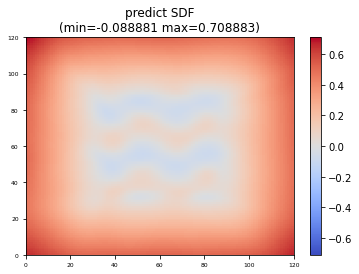

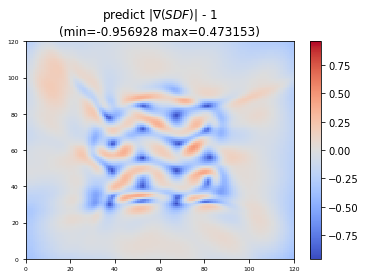

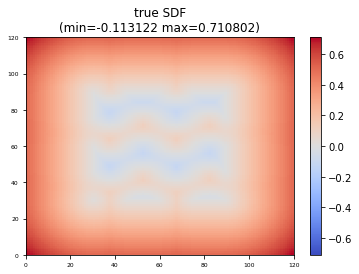

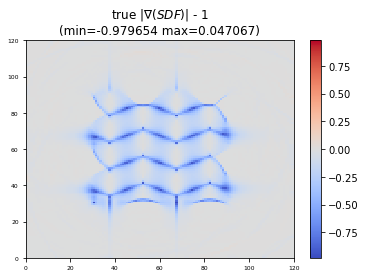

In [11]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0, step=0.05, offset=30, nums=120, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)